In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


### Graphs for Experiments

In [2]:
def build_obs(df, mapping):
    # take observed data and build targets of first 4 hours
    # Convert 'hour' to timedelta for proper grouping
    df["hour"] = df["hour"].sub(4)
    df['hour'] = pd.to_timedelta(df['hour'], unit='h')    
    # Group by time step and calculate the mean for each hour
    grouped = df.groupby(["ts_ind", pd.Grouper(key='hour', freq='1h')])[mapping].mean().reset_index()
    grouped["hour"] = grouped['hour'].dt.floor('H')
    grouped["hour"] = grouped.hour.astype(str).str.replace('0 days ', '')    
    # Create a complete set of expected hours
    expected_hours = pd.date_range(start='00:00:00', end='23:00:00', freq='1H').strftime('%H:%M:%S')

    # Create a DataFrame with all combinations of ts_ind and expected hours
    all_combinations = pd.DataFrame([(i, h) for i in grouped['ts_ind'].unique() for h in expected_hours], columns=['ts_ind', 'hour'])
    # Merge the calculated means with the DataFrame of all combinations
    grouped_filled = pd.merge(all_combinations, grouped, on=['ts_ind', 'hour'], how='left')

    return grouped_filled

def restore_predictions(predictions, mapping):
    # bring STraTS predicions in format for MSE
    l = []
    leng = len(predictions.iloc[0]) / len(mapping)
    for i in range(len(predictions)):
        arr = np.asarray(predictions.iloc[i]).reshape((int(leng),len(mapping)))
        l.append(arr)
    df = pd.concat([pd.DataFrame(arr) for arr in l])#, keys=np.arange(len(l)))
    
    df.columns=mapping
    return df

def mse_loss_with_nans(prediction, target, ax):

    # Mask missing values in target observations
    mask = pd.isna(target)

    # mean of the squared error along axis. 
    # axis 1 is column wise e.g. for each feature
    # axis 0 is row wise e.g. to get mse per timestep
    mse = np.mean((target[~mask]-prediction[~mask])**2, axis=ax)
    #mse = np.sum((target[~mask]-prediction)**2, axis=ax)


    return mse

### load data here for graph EXP1

c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


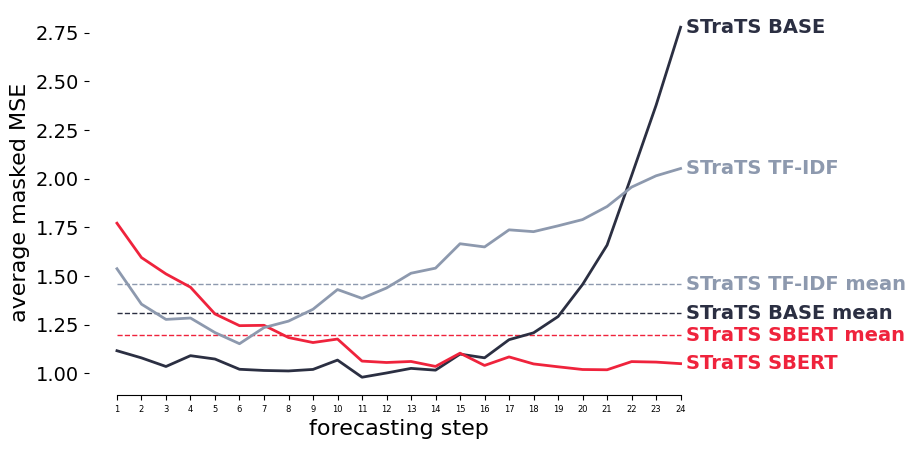

BASE 1 mean: 1.307107900848784
SBERT 1 mean: 1.1974752515721876
TF-IDF 1 mean: 1.455749010373615
noise 1 mean: 1.30308315885231


In [15]:
##EXP 1
with open("idfix_Unseeded4_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded4_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)


## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = noise_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets
only_lab_noise_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore,only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_1 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_1 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_1 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_1 = only_noise_st.groupby("step").mean()


notext_mean_1 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_1 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_1 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_1 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_1, notext_mean_1],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_1,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_1, sb_mean_1],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_1,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_1, tf_mean_1],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_1,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_1, only_sb_step_wise_mse_mean_1, only_tf_step_wise_mse_mean_1]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP1_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()

print("BASE 1 mean:", notext_mean_1)
print("SBERT 1 mean:", sb_mean_1)
print("TF-IDF 1 mean:", tf_mean_1)
print("noise 1 mean:", noise_mean_1)


### load data here for graph EXP2

c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


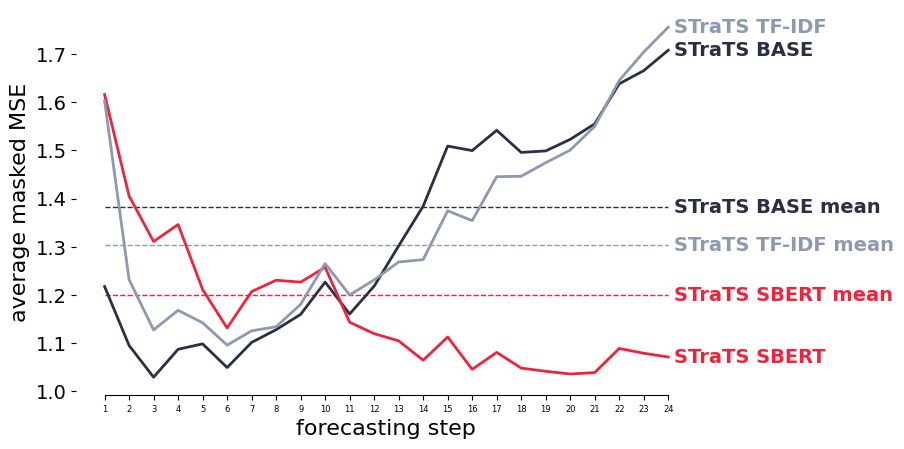

BASE 2 mean: 1.3828348639417998
SBERT 2 mean: 1.200242078588124
TF-IDF 2 mean: 1.30308315885231
noise 2 mean: 1.392530095790684


In [14]:
##EXP 2
with open("idfix_Unseeded5_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded5_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)

## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = notext_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_2 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_2 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_2 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_2 = only_noise_st.groupby("step").mean()


notext_mean_2 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_2 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_2 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_2 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_2, notext_mean_2],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_2,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_2, sb_mean_2],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_2,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_2, tf_mean_2],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_2,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_2, only_sb_step_wise_mse_mean_2, only_tf_step_wise_mse_mean_2]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP2_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()

print("BASE 2 mean:", notext_mean_2)
print("SBERT 2 mean:", sb_mean_2)
print("TF-IDF 2 mean:", tf_mean_2)
print("noise 2 mean:", noise_mean_2)


### load data here for graph EXP3

c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\pablo\miniconda3\envs\microsoft_sepsis\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


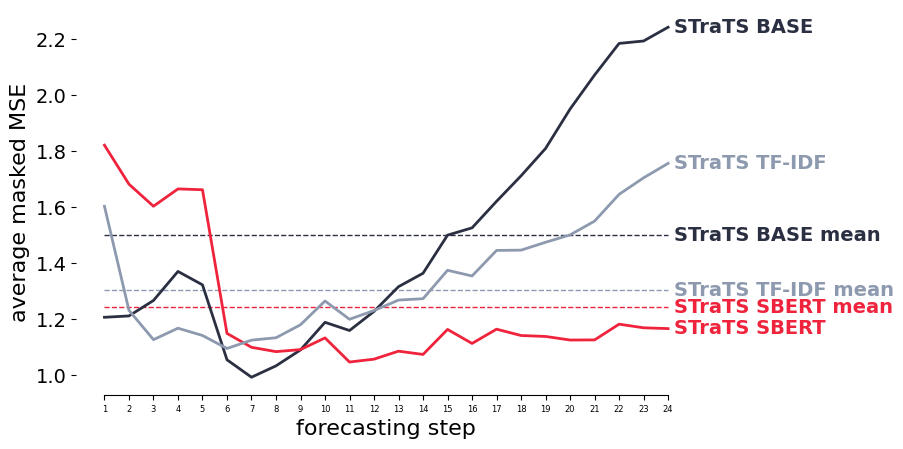

BASE 3 mean: 1.4997503832230048
SBERT 3 mean: 1.2436737241729694
TF-IDF 3 mean: 1.30308315885231
noise 3 mean: 1.5683979187117718


In [13]:
##EXP 3
with open("idfix_Unseeded6_notext_st_fo_targets_dump.pkl", "rb") as pfile:
    notext_st, notext_fo, notext_observe_targets, notext_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_sb_st_fo_targets_dump.pkl", "rb") as pfile:
    sb_st, sb_fo, sb_observe_targets, sb_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_tf_st_fo_targets_dump.pkl", "rb") as pfile:
    tf_st, tf_fo, tf_observe_targets, tf_var_map = pickle.load(pfile)
with open("idfix_Unseeded6_noise_st_fo_targets_dump.pkl", "rb") as pfile:
    noise_st, noise_fo, noise_observe_targets, noise_var_map = pickle.load(pfile)

## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
only_lab_noise_fore = noise_fo
only_lab_noise_target = notext_observe_targets

only_lab_sb_target = notext_observe_targets
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])
only_noise_st = pd.DataFrame(tf_step, columns=["step"])


only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")
only_noise_st = only_noise_st.reset_index().drop(columns="index")


## Stepwise MSE: 
#compute MSE for each step of each patient -> sum of one row / #features = MSE at step x for one patient. 
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_notext_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, 1)
only_noise_st["mse"] = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, 1)


## Stepwise MSE, Averaged over all patients -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_3 = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean_3 = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean_3 = only_tf_st.groupby("step").mean()
only_noise_step_wise_mse_mean_3 = only_noise_st.groupby("step").mean()


notext_mean_3 = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None)
sb_mean_3 = mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None)
tf_mean_3 = mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None)
noise_mean_3 = mse_loss_with_nans(only_lab_noise_fore, only_lab_notext_target, None)


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 5)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_3, notext_mean_3],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_3,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_3, sb_mean_3],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_3,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_3, tf_mean_3],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_3,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE"]
for frame in [only_notext_step_wise_mse_mean_3, only_sb_step_wise_mse_mean_3, only_tf_step_wise_mse_mean_3]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXP3_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()

print("BASE 3 mean:", notext_mean_3)
print("SBERT 3 mean:", sb_mean_3)
print("TF-IDF 3 mean:", tf_mean_3)
print("noise 3 mean:", noise_mean_3)


### graph AVG

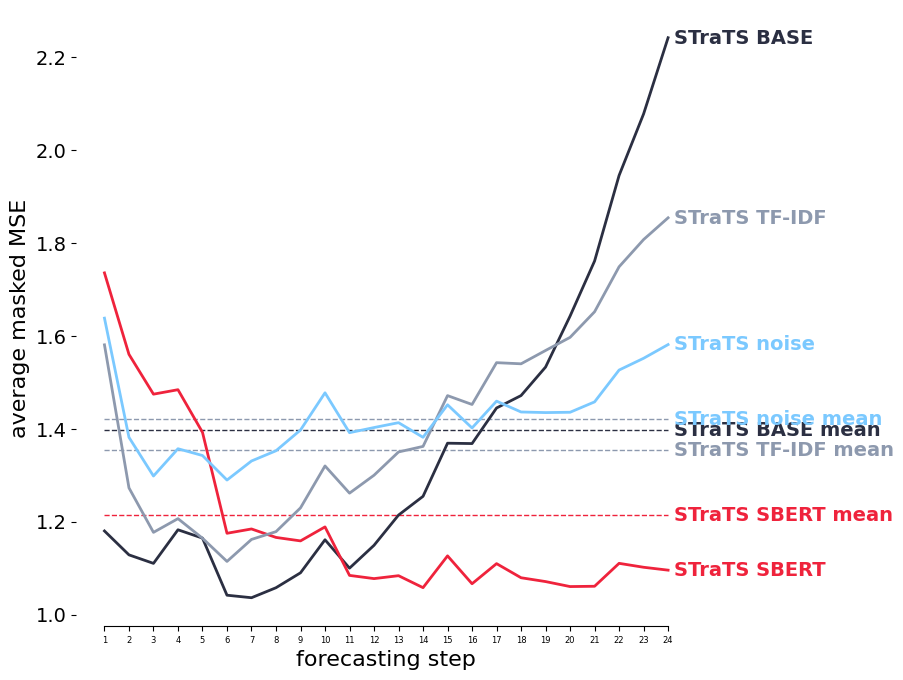

BASE avg mean: 1.3965643826711964
SBERT avg mean: 1.2137970181110938
TF-IDF avg mean: 1.3539717760260783
noise avg mean: 1.421337057784922


In [7]:
## Stepwise MSE, Averaged over all patients and all models -> (all feature errors of all patients at step x).mean()  
only_notext_step_wise_mse_mean_avg = (only_notext_step_wise_mse_mean_1 + only_notext_step_wise_mse_mean_2 + only_notext_step_wise_mse_mean_3) / 3
only_sb_step_wise_mse_mean_avg = (only_sb_step_wise_mse_mean_1 + only_sb_step_wise_mse_mean_2 + only_sb_step_wise_mse_mean_3) / 3
only_tf_step_wise_mse_mean_avg = (only_tf_step_wise_mse_mean_1 + only_tf_step_wise_mse_mean_2 + only_tf_step_wise_mse_mean_3) / 3
only_noise_step_wise_mse_mean_avg = (only_noise_step_wise_mse_mean_1 + only_noise_step_wise_mse_mean_2 + only_noise_step_wise_mse_mean_3) / 3


notext_mean_avg = (notext_mean_1 + notext_mean_2 + notext_mean_3) / 3 
sb_mean_avg = (sb_mean_1 + sb_mean_2 + sb_mean_3) / 3
tf_mean_avg = (tf_mean_1 + tf_mean_2 + tf_mean_3) / 3
noise_mean_avg = (noise_mean_1 + noise_mean_2 + noise_mean_3) / 3 


x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
labels = ['STraTS BASE','STraTS SBERT', 'STraTS TF-IDF', 'STraTS noise']
#labels = ['STraTS BASE', 'STraTS SBERT','STraTS NOISE']
fig, ax = plt.subplots(
    figsize=(8, 8)
)

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=5)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Plot the means
ax.plot(
    [x[0], max(x)],
    [notext_mean_avg, notext_mean_avg],
    label="STraTS BASE mean",
    color="#2B2F42",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    x[-1] * 1.01,
    notext_mean_avg,
    "STraTS BASE mean",
    color="#2B2F42",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [sb_mean_avg, sb_mean_avg],
    label="STraTS SBERT mean",
    color="#EF233C",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    sb_mean_avg,
    "STraTS SBERT mean",
    color="#EF233C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
ax.plot(
    [x[0], max(x)],
    [tf_mean_avg, tf_mean_avg],
    label="STraTS TF-IDF mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    tf_mean_avg,
    "STraTS TF-IDF mean",
    color="#8D99AE",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

ax.plot(
    [x[0], max(x)],
    [noise_mean_avg, noise_mean_avg],
    label="STraTS noise mean",
    color="#8D99AE",
    linestyle="--",
    linewidth=1,
)
ax.text(
    x[-1] * 1.01,
    noise_mean_avg,
    "STraTS noise mean",
    color="#7BC9FF",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)
i, colors = 0, ["#2B2F42", "#EF233C", "#8D99AE", "#7BC9FF"]
for frame in [only_notext_step_wise_mse_mean_avg, only_sb_step_wise_mse_mean_avg, only_tf_step_wise_mse_mean_avg, only_noise_step_wise_mse_mean_avg]:
    ax.plot(x, frame, color=colors[i], label=labels[i], linewidth=2)
    ax.text(
        x[-1] * 1.01,
        frame.iloc[-1],
        labels[i],
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
   
    i+=1
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_xticks(np.arange(min(x), max(x) + 1))
ax.set_xlabel("forecasting step")
ax.set_ylabel("average masked MSE")
ax.tick_params(axis='x', labelsize=6)
plt.savefig("EXPAVG_stepwiseMSE.png", dpi=300,bbox_inches = 'tight')
plt.show()

print("BASE avg mean:", notext_mean_avg)
print("SBERT avg mean:", sb_mean_avg)
print("TF-IDF avg mean:", tf_mean_avg)
print("noise avg mean:", noise_mean_avg)

In [8]:
m = only_notext_st["mse"].isna()
print(m.value_counts())
only_lab_notext_target[m].isna().value_counts()
(174017+2335) / 24

mse
False    174017
True       2335
Name: count, dtype: int64


7348.0

In [10]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(3)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

lab_missing = missing_values_table(notext_observe_targets)
text_missing = missing_values_table(sb_observe_targets)
print(lab_missing["% of Total Values"].mean())
print(text_missing["% of Total Values"].mean())

Your selected dataframe has 133 columns.
There are 133 columns that have missing values.
Your selected dataframe has 183 columns.
There are 183 columns that have missing values.
89.79281954887217
88.30653005464481


In [11]:
for i in range(len(lab_missing)):
    print(i, lab_missing.iloc[i])

0 Missing Values       176339.000
% of Total Values        99.993
Name: Lymphocytes (Absolute), dtype: float64
1 Missing Values       176299.00
% of Total Values        99.97
Name: Insulin NPH, dtype: float64
2 Missing Values       176210.000
% of Total Values        99.919
Name: Levofloxacin, dtype: float64
3 Missing Values       176195.000
% of Total Values        99.911
Name: Residual, dtype: float64
4 Missing Values       176107.000
% of Total Values        99.861
Name: Free Water, dtype: float64
5 Missing Values       176092.000
% of Total Values        99.853
Name: Ultrafiltrate, dtype: float64
6 Missing Values       176085.000
% of Total Values        99.849
Name: Bilirubin (Indirect), dtype: float64
7 Missing Values       176068.000
% of Total Values        99.839
Name: Albumin 25%, dtype: float64
8 Missing Values       176059.000
% of Total Values        99.834
Name: Bilirubin (Direct), dtype: float64
9 Missing Values       175985.000
% of Total Values        99.792
Name: Pre-

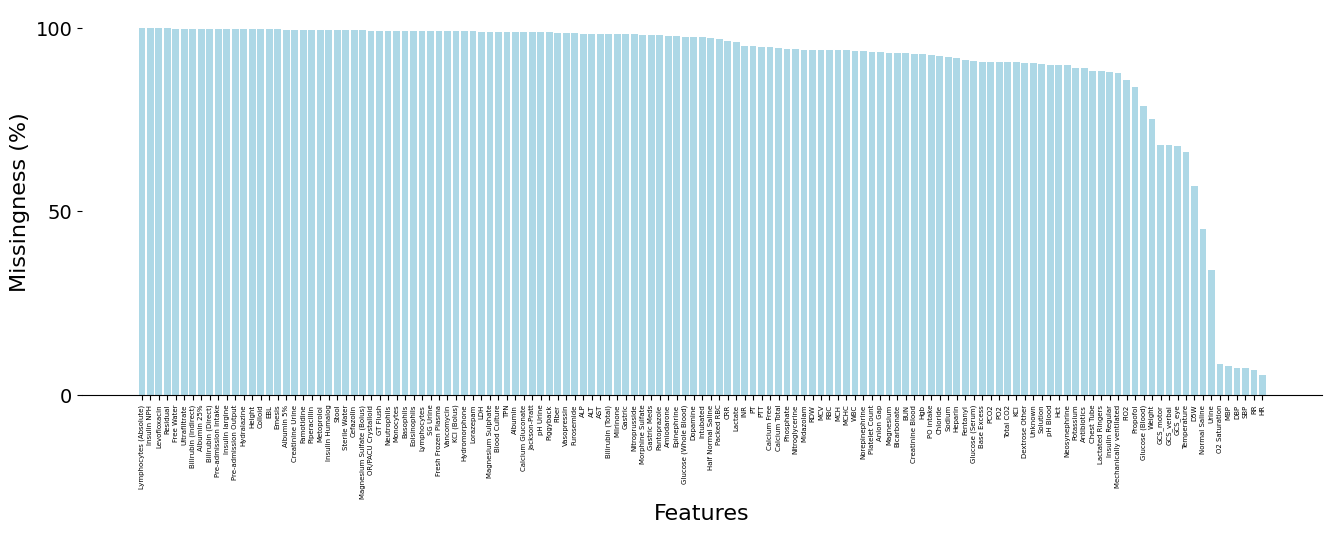

In [12]:
fig, ax = plt.subplots(
    figsize=(16, 5)
)

# Define font sizes
SIZE_SMALL = 6
SIZE_DEFAULT = 14
SIZE_LARGE = 16
#plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

x = range(0,101)
ax.bar(lab_missing.index, lab_missing["% of Total Values"].values, color="lightblue", linewidth=1)
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.spines["bottom"].set_bounds(min(x), max(x))
ax.set_yticks([0,50,100])
ax.set_xlabel("Features")
ax.set_ylabel("Missingness (%)")
plt.xticks(rotation=90)
#plt.xlim(0,18000)
#plt.ylim(0,30)
#plt.title("Average MSE from forecasting step 1 to 24")
#plt.xlabel("forecasting step")
#plt.ylabel("Average of MSE (over testset)")
#ax.legend()
plt.savefig("testsetMISSINGNESS.png", dpi=300,bbox_inches = 'tight')
plt.show()
